# PART One – Multiclass Classification

---



1. Data Pre-Processing


In [ ]:
# Dataset Download
import kagglehub

path = kagglehub.dataset_download("puneet6060/intel-image-classification")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'intel-image-classification' dataset.
Path to dataset files: /kaggle/input/intel-image-classification


In [ ]:
# Core libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow / Keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Base dataset directory
BASE_DIR = "/kaggle/input/intel-image-classification"

# Training and testing directories
train_dir = BASE_DIR + "/seg_train/seg_train"
test_dir  = BASE_DIR + "/seg_test/seg_test"

# Verify class folders
print("Training classes:", os.listdir(train_dir))


Training classes: ['mountain', 'street', 'buildings', 'sea', 'forest', 'glacier']


In [ ]:
# Image size for resizing
IMG_SIZE = 150

# Batch size for training
BATCH_SIZE = 32

In [ ]:
# Image Preprocessing & Normalisation

train_datagen = ImageDataGenerator(
    rescale=1./255,          # Normalisation
    validation_split=0.2     # 80% training, 20% validation
)

test_datagen = ImageDataGenerator(
    rescale=1./255           # Normalisation only
)


In [ ]:
# Create Data Generators

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


**Visualise Sample Images**

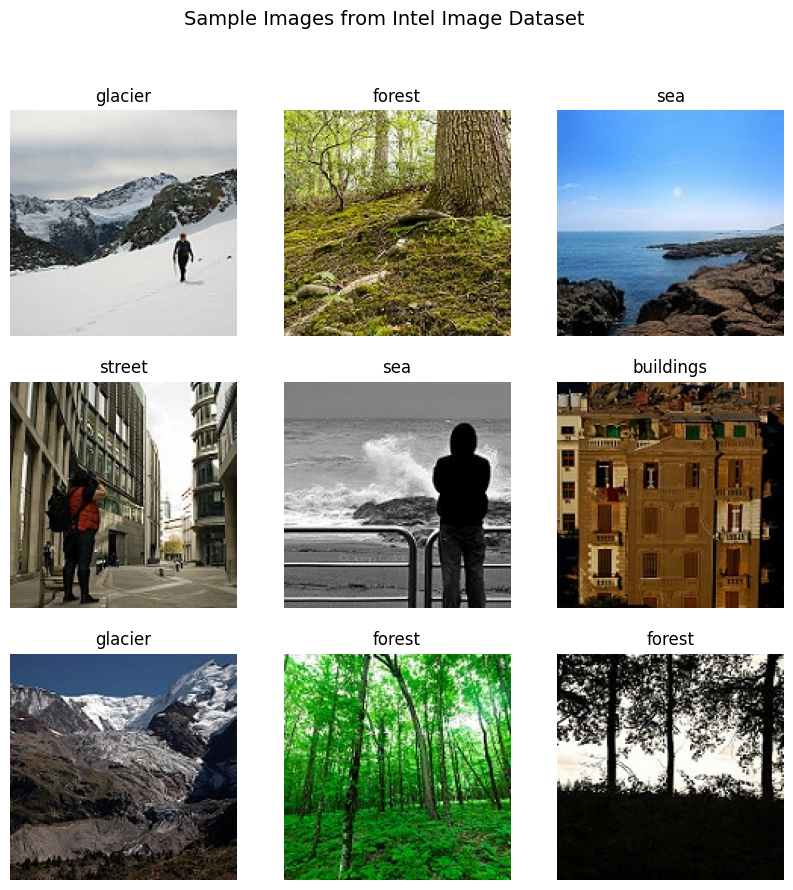

In [ ]:
# Get class names
class_names = list(train_generator.class_indices.keys())

# Fetch one batch
images, labels = next(train_generator)

# Plot sample images
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i])
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis('off')

plt.suptitle("Sample Images from Intel Image Dataset", fontsize=14)
plt.show()


**Class Distribution Analysis**

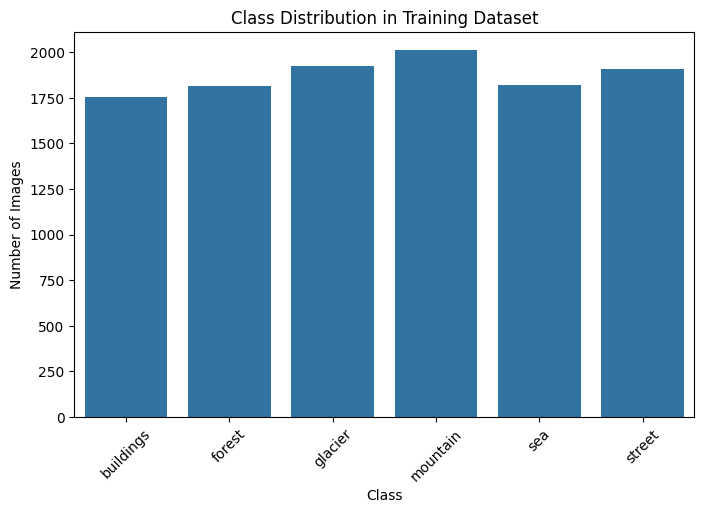

In [ ]:
# Extract class indices
class_counts = train_generator.classes

# Plot distribution
plt.figure(figsize=(8,5))
sns.countplot(x=class_counts)
plt.xticks(
    ticks=range(len(class_names)),
    labels=class_names,
    rotation=45
)
plt.title("Class Distribution in Training Dataset")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()


2. Model Implementation & Training


Model 1: Machine Learning – Logistic Regression

In [1]:
# Load Images Manually
import cv2
import numpy as np
import os

IMG_SIZE_LR = 64   # Reduced size to lower dimensionality

def load_images_for_lr(base_dir, limit_per_class=300):
    X, y = [], []
    class_names = sorted(os.listdir(base_dir))

    for label, class_name in enumerate(class_names):
        class_path = os.path.join(base_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        for img_name in os.listdir(class_path)[:limit_per_class]:
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (IMG_SIZE_LR, IMG_SIZE_LR))
            img = img / 255.0
            X.append(img)
            y.append(label)

    return np.array(X), np.array(y), class_names


In [ ]:
# Load & Prepare Data
X_train_lr, y_train_lr, class_names_lr = load_images_for_lr(train_dir)
X_test_lr, y_test_lr, _ = load_images_for_lr(test_dir)

# Flatten images
X_train_lr = X_train_lr.reshape(X_train_lr.shape[0], -1)
X_test_lr = X_test_lr.reshape(X_test_lr.shape[0], -1)


In [ ]:
# Train Logistic Regression
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(
    max_iter=1000,
    n_jobs=-1
)

lr_model.fit(X_train_lr, y_train_lr)


LogisticRegression(max_iter=1000, n_jobs=-1)

In [ ]:
# Evaluate
from sklearn.metrics import accuracy_score, classification_report

y_pred_lr = lr_model.predict(X_test_lr)

print("Logistic Regression Accuracy:", accuracy_score(y_test_lr, y_pred_lr))
print(classification_report(y_test_lr, y_pred_lr))


Logistic Regression Accuracy: 0.445
              precision    recall  f1-score   support

           0       0.37      0.24      0.29       300
           1       0.75      0.62      0.68       300
           2       0.40      0.43      0.42       300
           3       0.43      0.62      0.51       300
           4       0.29      0.35      0.32       300
           5       0.52      0.40      0.45       300

    accuracy                           0.45      1800
   macro avg       0.46      0.45      0.44      1800
weighted avg       0.46      0.45      0.44      1800



Model 2: Artificial Neural Network (ANN) – Keras

In [ ]:
# Build ANN Architecture

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

ann_model = Sequential([
    Flatten(input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(6, activation='softmax')
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Compile ANN

ann_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

ann_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 67500)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     8,640,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,648,774 (32.99 MB)

 Trainable params: 8,648,774 (32.99 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train ANN

ann_history = ann_model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 72s 198ms/step - accuracy: 0.3208 - loss: 6.5995 - val_accuracy: 0.4415 - val_loss: 2.9931
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.4361 - loss: 2.0260 - val_accuracy: 0.4240 - val_loss: 1.5980
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - accuracy: 0.4915 - loss: 1.6006 - val_accuracy: 0.2924 - val_loss: 2.9052
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.4922 - loss: 1.4378 - val_accuracy: 0.4747 - val_loss: 1.3604
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - accuracy: 0.5370 - loss: 1.2639 - val_accuracy: 0.5068 - val_loss: 1.3018
Epoch 6/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.5661 - loss: 1.1861 - val_accuracy: 0.4155 - val_loss: 1.6187
Epoch 7/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - accuracy: 0.5539 - loss: 1.1743 - val_accuracy: 0.5317 - val_loss: 1.3049
Epoch 8/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.5579 - loss: 1.1660 -

In [ ]:
# Evaluate ANN

ann_loss, ann_acc = ann_model.evaluate(test_generator)
print("ANN Test Accuracy:", ann_acc)


94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 97ms/step - accuracy: 0.4513 - loss: 1.4909
ANN Test Accuracy: 0.4033333361148834


Model 3: Convolutional Neural Network (CNN) – Keras

In [ ]:
# Build CNN Architecture

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam

cnn_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compile CNN

cnn_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

cnn_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │    10,616,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,637,126 (40.58 MB)

 Trainable params: 10,637,126 (40.58 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train CNN

cnn_history = cnn_model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)


Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 27s 63ms/step - accuracy: 0.4549 - loss: 1.4716 - val_accuracy: 0.6608 - val_loss: 0.8789
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 18s 52ms/step - accuracy: 0.6351 - loss: 0.9301 - val_accuracy: 0.6915 - val_loss: 0.7988
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.7064 - loss: 0.7642 - val_accuracy: 0.7582 - val_loss: 0.6808
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 18s 52ms/step - accuracy: 0.7746 - loss: 0.6160 - val_accuracy: 0.7853 - val_loss: 0.6137
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 18s 51ms/step - accuracy: 0.8248 - loss: 0.4930 - val_accuracy: 0.8017 - val_loss: 0.6042
Epoch 6/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 18s 52ms/step - accuracy: 0.8654 - loss: 0.3719 - val_accuracy: 0.8021 - val_loss: 0.6390
Epoch 7/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 18s 51ms/step - accuracy: 0.8853 - loss: 0.3186 - val_accuracy: 0.8163 - val_loss: 0.5987
Epoch 8/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 18s 52ms/step - accuracy: 0.9110 - loss: 0.2476 - 

In [ ]:
# Evaluate CNN

cnn_loss, cnn_acc = cnn_model.evaluate(test_generator)
print("CNN Test Accuracy:", cnn_acc)


94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.7369 - loss: 1.3304
CNN Test Accuracy: 0.7636666893959045


3. Model Evaluation

In [ ]:
# Helper Function: Plot Confusion Matrix

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, class_names, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(
        cm,
        annot=False,
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()


Model 1 Evaluation: Logistic Regression

In [ ]:
# Accuracy & Classification Report

from sklearn.metrics import accuracy_score, classification_report

print("Logistic Regression Accuracy:",
      accuracy_score(y_test_lr, y_pred_lr))

print("\nLogistic Regression Classification Report:\n")
print(classification_report(y_test_lr, y_pred_lr, target_names=class_names_lr))


Logistic Regression Accuracy: 0.4444444444444444

Logistic Regression Classification Report:

              precision    recall  f1-score   support

   buildings       0.38      0.24      0.29       300
      forest       0.75      0.62      0.68       300
     glacier       0.40      0.44      0.42       300
    mountain       0.43      0.62      0.50       300
         sea       0.29      0.36      0.32       300
      street       0.51      0.40      0.45       300

    accuracy                           0.44      1800
   macro avg       0.46      0.44      0.44      1800
weighted avg       0.46      0.44      0.44      1800



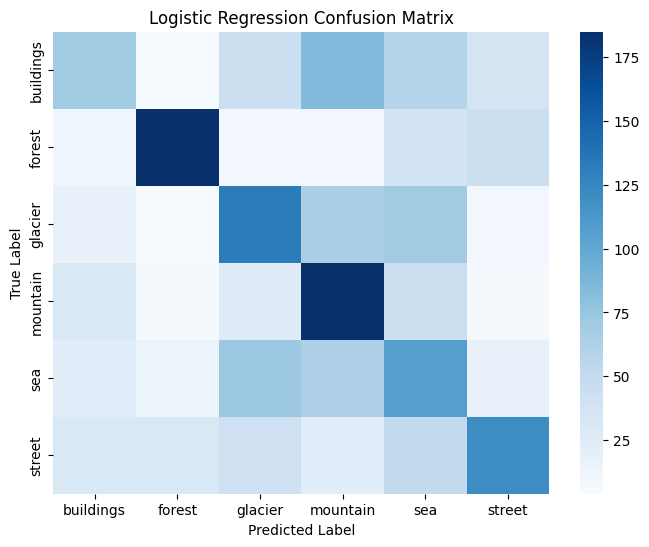

In [ ]:
# Confusion Matrix

plot_confusion_matrix(
    y_test_lr,
    y_pred_lr,
    class_names_lr,
    "Logistic Regression Confusion Matrix"
)


Model 2 Evaluation: ANN

In [ ]:
# Generate Predictions

import numpy as np

y_pred_ann_prob = ann_model.predict(test_generator)
y_pred_ann = np.argmax(y_pred_ann_prob, axis=1)
y_true_ann = test_generator.classes


94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step


In [ ]:
# Accuracy & Classification Report
print("ANN Accuracy:",
      accuracy_score(y_true_ann, y_pred_ann))

print("\nANN Classification Report:\n")
print(classification_report(y_true_ann, y_pred_ann, target_names=class_names))

ANN Accuracy: 0.4033333333333333

ANN Classification Report:

              precision    recall  f1-score   support

   buildings       0.43      0.34      0.38       437
      forest       0.30      0.92      0.45       474
     glacier       0.75      0.12      0.21       553
    mountain       0.52      0.53      0.52       525
         sea       0.32      0.21      0.25       510
      street       0.74      0.34      0.46       501

    accuracy                           0.40      3000
   macro avg       0.51      0.41      0.38      3000
weighted avg       0.51      0.40      0.38      3000



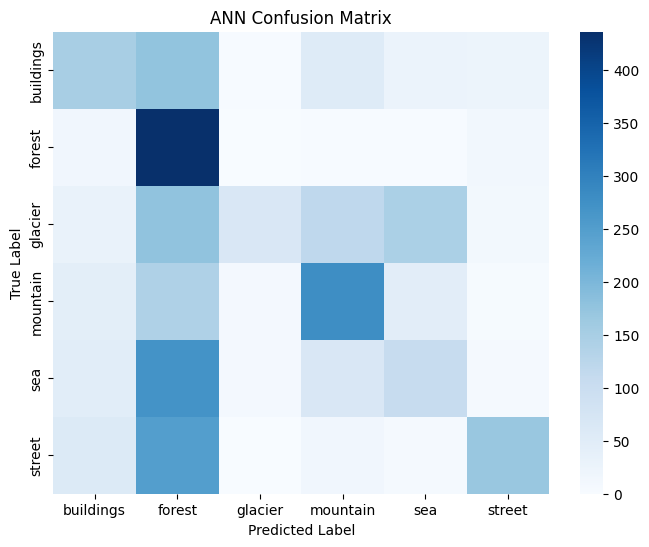

In [ ]:
# Confusion Matrix
plot_confusion_matrix(
    y_true_ann,
    y_pred_ann,
    class_names,
    "ANN Confusion Matrix"
)

Model 3 Evaluation: CNN

In [ ]:
# Generate Predictions
y_pred_cnn_prob = cnn_model.predict(test_generator)
y_pred_cnn = np.argmax(y_pred_cnn_prob, axis=1)
y_true_cnn = test_generator.classes

94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step


In [ ]:
# Accuracy & Classification Report
print("CNN Accuracy:",
      accuracy_score(y_true_cnn, y_pred_cnn))

print("\nCNN Classification Report:\n")
print(classification_report(y_true_cnn, y_pred_cnn, target_names=class_names))

CNN Accuracy: 0.7636666666666667

CNN Classification Report:

              precision    recall  f1-score   support

   buildings       0.82      0.65      0.72       437
      forest       0.98      0.86      0.92       474
     glacier       0.69      0.77      0.73       553
    mountain       0.65      0.79      0.71       525
         sea       0.78      0.66      0.71       510
      street       0.77      0.85      0.80       501

    accuracy                           0.76      3000
   macro avg       0.78      0.76      0.77      3000
weighted avg       0.78      0.76      0.76      3000



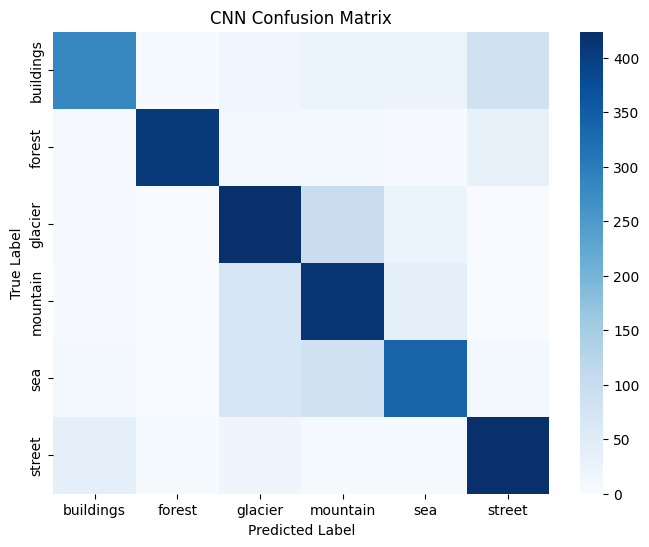

In [ ]:
# Confusion Matrix
plot_confusion_matrix(
    y_true_cnn,
    y_pred_cnn,
    class_names,
    "CNN Confusion Matrix"
)

**Grad-CAM Explainability for CNN**

In [ ]:
# Import required libraries
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
# Function: Generate Grad-CAM heatmap
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    """
    Generates a Grad-CAM heatmap for a given image and trained CNN model.

    Parameters:
    - img_array: Preprocessed image array of shape (1, H, W, 3)
    - model: Trained CNN model
    - last_conv_layer_name: Name of the last convolutional layer in the CNN

    Returns:
    - heatmap: Normalized Grad-CAM heatmap
    """

    # Ensure the model is fully built by running a forward pass
    # This is required when using Sequential models trained with generators
    _ = model(img_array)

    # Create a model that maps the input image to:
    # 1) Activations of the last convolutional layer
    # 2) Final output predictions
    grad_model = tf.keras.models.Model(
        inputs=model.layers[0].input,
        outputs=[
            model.get_layer(last_conv_layer_name).output,
            model.layers[-1].output
        ]
    )

    # Record operations for automatic differentiation
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)

        # Identify the predicted class index
        pred_index = tf.argmax(predictions[0])

        # Extract the score corresponding to the predicted class
        class_channel = predictions[:, pred_index]

    # Compute gradients of the predicted class score
    # with respect to the convolutional feature maps
    grads = tape.gradient(class_channel, conv_outputs)

    # Perform global average pooling on the gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Extract the feature maps of the last convolutional layer
    conv_outputs = conv_outputs[0]

    # Weight the feature maps by the pooled gradients
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Apply ReLU to focus only on positive contributions
    heatmap = tf.maximum(heatmap, 0)

    # Normalize the heatmap for visualization
    heatmap /= tf.reduce_max(heatmap) + tf.keras.backend.epsilon()

    return heatmap.numpy()

In [ ]:
# Load and preprocess a test image
img_path = test_generator.filepaths[0]

# Load image and resize
img = tf.keras.preprocessing.image.load_img(
    img_path, target_size=(IMG_SIZE, IMG_SIZE)
)

# Convert image to array and normalize
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

In [ ]:
# Generate Grad-CAM heatmap
last_conv_layer_name = "conv2d_1"  # Last convolutional layer in the CNN

heatmap = make_gradcam_heatmap(
    img_array,
    cnn_model,
    last_conv_layer_name
)


In [ ]:
# Overlay heatmap on original image
# Load original image using OpenCV
original_img = cv2.imread(img_path)
original_img = cv2.resize(original_img, (IMG_SIZE, IMG_SIZE))

# Resize heatmap to match image dimensions
heatmap_resized = cv2.resize(heatmap, (IMG_SIZE, IMG_SIZE))
heatmap_resized = np.uint8(255 * heatmap_resized)

# Apply color map for better visualization
heatmap_colored = cv2.applyColorMap(
    heatmap_resized, cv2.COLORMAP_JET
)

# Superimpose heatmap on original image
superimposed_img = cv2.addWeighted(
    original_img, 0.6, heatmap_colored, 0.4, 0)

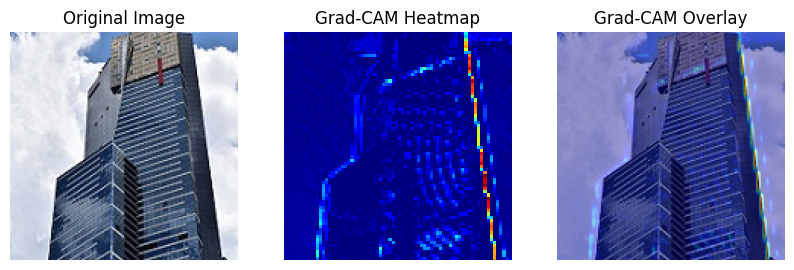

In [ ]:
# Display results
plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Grad-CAM Heatmap")
plt.imshow(heatmap, cmap="jet")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Grad-CAM Overlay")
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
import kagglehub

path = kagglehub.dataset_download("thedevastator/epa-air-quality-data")
print("Path to dataset files:", path)


Using Colab cache for faster access to the 'epa-air-quality-data' dataset.
Path to dataset files: /kaggle/input/epa-air-quality-data


In [ ]:
df = pd.read_csv(path + "/rows.csv")


In [ ]:
df.head()


,index,MeasureId,MeasureName,MeasureType,StratificationLevel,StateFips,StateName,CountyFips,CountyName,ReportYear,Value,Unit,UnitName,DataOrigin,MonitorOnly
0,0,83,Number of days with maximum 8-hour average ozo...,Counts,State x County,1,Alabama,1051,Elmore,1999,5.0,No Units,No Units,Monitor Only,1
1,1,83,Number of days with maximum 8-hour average ozo...,Counts,State x County,1,Alabama,1073,Jefferson,1999,39.0,No Units,No Units,Monitor Only,1
2,2,83,Number of days with maximum 8-hour average ozo...,Counts,State x County,1,Alabama,1079,Lawrence,1999,28.0,No Units,No Units,Monitor Only,1
3,3,83,Number of days with maximum 8-hour average ozo...,Counts,State x County,1,Alabama,1089,Madison,1999,31.0,No Units,No Units,Monitor Only,1
4,4,83,Number of days with maximum 8-hour average ozo...,Counts,State x County,1,Alabama,1097,Mobile,1999,32.0,No Units,No Units,Monitor Only,1


In [ ]:
df.shape

(218635, 15)

In [ ]:
df.columns


Index(['index', 'MeasureId', 'MeasureName', 'MeasureType',
       'StratificationLevel', 'StateFips', 'StateName', 'CountyFips',
       'CountyName', 'ReportYear', 'Value', 'Unit', 'UnitName', 'DataOrigin',
       'MonitorOnly'],
      dtype='object')

In [ ]:
df.describe()


,index,MeasureId,StateFips,CountyFips,ReportYear,Value,MonitorOnly
count,218635.00000,218635.000000,218635.000000,218635.000000,218635.000000,2.186350e+05,218635.000000
mean,109317.00000,248.436979,30.228980,30328.039536,2005.997777,6.499649e+05,0.383950
std,63114.63239,86.333124,15.139346,15157.173159,3.432221,1.160826e+07,0.486347
min,0.00000,83.000000,1.000000,1001.000000,1999.000000,0.000000e+00,0.000000
25%,54658.50000,292.000000,18.000000,18146.000000,2003.000000,0.000000e+00,0.000000
50%,109317.00000,293.000000,29.000000,29189.000000,2006.000000,2.000000e+00,0.000000
75%,163975.50000,295.000000,45.000000,45021.000000,2009.000000,1.394105e+01,1.000000
max,218634.00000,296.000000,56.000000,56045.000000,2013.000000,1.084153e+09,1.000000


In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218635 entries, 0 to 218634
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   index                218635 non-null  int64  
 1   MeasureId            218635 non-null  int64  
 2   MeasureName          218635 non-null  object 
 3   MeasureType          218635 non-null  object 
 4   StratificationLevel  218635 non-null  object 
 5   StateFips            218635 non-null  int64  
 6   StateName            218635 non-null  object 
 7   CountyFips           218635 non-null  int64  
 8   CountyName           218635 non-null  object 
 9   ReportYear           218635 non-null  int64  
 10  Value                218635 non-null  float64
 11  Unit                 218635 non-null  object 
 12  UnitName             218635 non-null  object 
 13  DataOrigin           218635 non-null  object 
 14  MonitorOnly          218635 non-null  int64  
dtypes: float64(1), in

In [ ]:
# Select only numerical columns
df_numeric = df.select_dtypes(include=['int64', 'float64'])

df_numeric.head()



,index,MeasureId,StateFips,CountyFips,ReportYear,Value,MonitorOnly
0,0,83,1,1051,1999,5.0,1
1,1,83,1,1073,1999,39.0,1
2,2,83,1,1079,1999,28.0,1
3,3,83,1,1089,1999,31.0,1
4,4,83,1,1097,1999,32.0,1


In [ ]:
df_numeric.columns


Index(['index', 'MeasureId', 'StateFips', 'CountyFips', 'ReportYear', 'Value',
       'MonitorOnly'],
      dtype='object')

In [ ]:
# Drop identifier columns if they exist
cols_to_drop = [col for col in df_numeric.columns if 'id' in col.lower()]

df_cluster = df_numeric.drop(columns=cols_to_drop)


In [ ]:
df_cluster.isnull().sum()


,0
index,0
StateFips,0
CountyFips,0
ReportYear,0
Value,0
MonitorOnly,0


In [ ]:
# Remove rows with missing values
df_cluster = df_cluster.dropna()


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)


In [ ]:
from sklearn.cluster import KMeans

inertia = []
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)


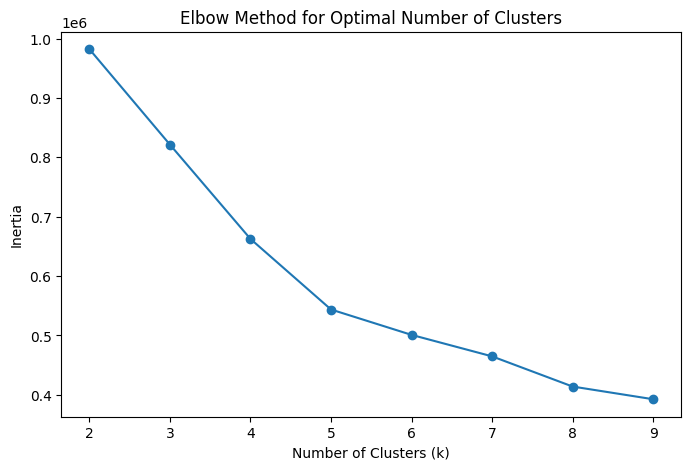

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(K_range, inertia, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal Number of Clusters")
plt.show()


In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)


In [ ]:
df_cluster['Cluster'] = clusters

df_cluster.head()


,index,StateFips,CountyFips,ReportYear,Value,MonitorOnly,Cluster
0,0,1,1051,1999,5.0,1,0
1,1,1,1073,1999,39.0,1,0
2,2,1,1079,1999,28.0,1,0
3,3,1,1089,1999,31.0,1,0
4,4,1,1097,1999,32.0,1,0


In [ ]:
from sklearn.metrics import silhouette_score

sil_score = silhouette_score(X_scaled, clusters)
print("Silhouette Score:", sil_score)


# Part Two - Clustering Analysis
---

In [ ]:
# ==============================
# Step 1: Import libraries
# ==============================

import pandas as pd
import numpy as np

# Visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Explainable AI
import shap

# Kaggle dataset downloader
import kagglehub


In [ ]:
# ==============================
# Step 2: Load EPA Air Quality dataset
# ==============================

path = kagglehub.dataset_download("thedevastator/epa-air-quality-data")
df = pd.read_csv(f"{path}/rows.csv")

# Preview dataset
df.head()

Using Colab cache for faster access to the 'epa-air-quality-data' dataset.


,index,MeasureId,MeasureName,MeasureType,StratificationLevel,StateFips,StateName,CountyFips,CountyName,ReportYear,Value,Unit,UnitName,DataOrigin,MonitorOnly
0,0,83,Number of days with maximum 8-hour average ozo...,Counts,State x County,1,Alabama,1051,Elmore,1999,5.0,No Units,No Units,Monitor Only,1
1,1,83,Number of days with maximum 8-hour average ozo...,Counts,State x County,1,Alabama,1073,Jefferson,1999,39.0,No Units,No Units,Monitor Only,1
2,2,83,Number of days with maximum 8-hour average ozo...,Counts,State x County,1,Alabama,1079,Lawrence,1999,28.0,No Units,No Units,Monitor Only,1
3,3,83,Number of days with maximum 8-hour average ozo...,Counts,State x County,1,Alabama,1089,Madison,1999,31.0,No Units,No Units,Monitor Only,1
4,4,83,Number of days with maximum 8-hour average ozo...,Counts,State x County,1,Alabama,1097,Mobile,1999,32.0,No Units,No Units,Monitor Only,1


In [ ]:
# Dataset structure
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218635 entries, 0 to 218634
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   index                218635 non-null  int64  
 1   MeasureId            218635 non-null  int64  
 2   MeasureName          218635 non-null  object 
 3   MeasureType          218635 non-null  object 
 4   StratificationLevel  218635 non-null  object 
 5   StateFips            218635 non-null  int64  
 6   StateName            218635 non-null  object 
 7   CountyFips           218635 non-null  int64  
 8   CountyName           218635 non-null  object 
 9   ReportYear           218635 non-null  int64  
 10  Value                218635 non-null  float64
 11  Unit                 218635 non-null  object 
 12  UnitName             218635 non-null  object 
 13  DataOrigin           218635 non-null  object 
 14  MonitorOnly          218635 non-null  int64  
dtypes: float64(1), in

In [ ]:
# Summary statistics for numerical features
df.describe()


,index,MeasureId,StateFips,CountyFips,ReportYear,Value,MonitorOnly
count,218635.00000,218635.000000,218635.000000,218635.000000,218635.000000,2.186350e+05,218635.000000
mean,109317.00000,248.436979,30.228980,30328.039536,2005.997777,6.499649e+05,0.383950
std,63114.63239,86.333124,15.139346,15157.173159,3.432221,1.160826e+07,0.486347
min,0.00000,83.000000,1.000000,1001.000000,1999.000000,0.000000e+00,0.000000
25%,54658.50000,292.000000,18.000000,18146.000000,2003.000000,0.000000e+00,0.000000
50%,109317.00000,293.000000,29.000000,29189.000000,2006.000000,2.000000e+00,0.000000
75%,163975.50000,295.000000,45.000000,45021.000000,2009.000000,1.394105e+01,1.000000
max,218634.00000,296.000000,56.000000,56045.000000,2013.000000,1.084153e+09,1.000000


In [ ]:
# ==============================
# Step 4: Feature selection
# ==============================

df = df[
    [
        'Value',          # Target variable
        'MeasureName',    # Pollutant type
        'ReportYear',
        'StateFips',
        'CountyFips'
    ]
]

df.head()


,Value,MeasureName,ReportYear,StateFips,CountyFips
0,5.0,Number of days with maximum 8-hour average ozo...,1999,1,1051
1,39.0,Number of days with maximum 8-hour average ozo...,1999,1,1073
2,28.0,Number of days with maximum 8-hour average ozo...,1999,1,1079
3,31.0,Number of days with maximum 8-hour average ozo...,1999,1,1089
4,32.0,Number of days with maximum 8-hour average ozo...,1999,1,1097


In [ ]:
# ==============================
# Step 5: Missing value handling
# ==============================

df.isnull().sum()


,0
Value,0
MeasureName,0
ReportYear,0
StateFips,0
CountyFips,0


In [ ]:
# Remove rows with missing values
df = df.dropna()

print("Dataset shape after dropping missing values:", df.shape)


Dataset shape after dropping missing values: (218635, 5)


In [ ]:
# ==============================
# Step 6: Encode categorical feature
# ==============================

df = pd.get_dummies(df, columns=['MeasureName'], drop_first=True)

df.head()


,Value,ReportYear,StateFips,CountyFips,MeasureName_Annual average ambient concentrations of PM2.5 in micrograms per cubic meter (based on seasonal averages and daily measurement),MeasureName_Number of days with maximum 8-hour average ozone concentration over the National Ambient Air Quality Standard,MeasureName_Number of days with maximum 8-hour average ozone concentration over the National Ambient Air Quality Standard (monitor and modeled data),MeasureName_Number of person-days with PM2.5 over the National Ambient Air Quality Standard (monitor and modeled data),MeasureName_Number of person-days with maximum 8-hour average ozone concentration over the National Ambient Air Quality Standard,MeasureName_Number of person-days with maximum 8-hour average ozone concentration over the National Ambient Air Quality Standard (monitor and modeled data),MeasureName_Percent of days with PM2.5 levels over the National Ambient Air Quality Standard (NAAQS),MeasureName_Percent of days with PM2.5 levels over the National Ambient Air Quality Standard (monitor and modeled data),MeasureName_Person-days with PM2.5 over the National Ambient Air Quality Standard
0,5.0,1999,1,1051,False,True,False,False,False,False,False,False,False
1,39.0,1999,1,1073,False,True,False,False,False,False,False,False,False
2,28.0,1999,1,1079,False,True,False,False,False,False,False,False,False
3,31.0,1999,1,1089,False,True,False,False,False,False,False,False,False
4,32.0,1999,1,1097,False,True,False,False,False,False,False,False,False


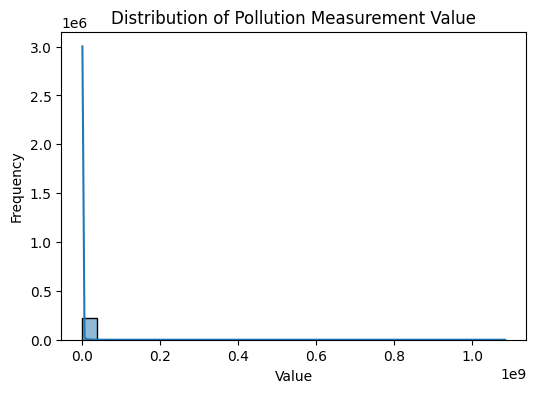

In [ ]:
plt.figure(figsize=(6,4))
sns.histplot(df['Value'], bins=30, kde=True)
plt.title("Distribution of Pollution Measurement Value")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()


In [ ]:
# ==============================
# Step 8: Log transformation
# ==============================

# Log-transform target to handle skewness and extreme outliers
df['Value_log'] = np.log1p(df['Value'])  # log(1 + x) avoids log(0)


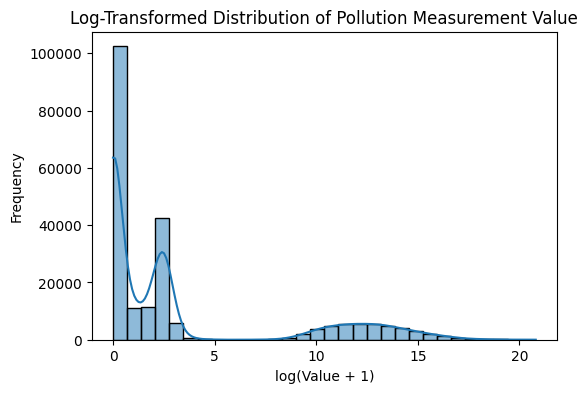

In [ ]:
# Visualise transformed distribution
plt.figure(figsize=(6,4))
sns.histplot(df['Value_log'], bins=30, kde=True)
plt.title("Log-Transformed Distribution of Pollution Measurement Value")
plt.xlabel("log(Value + 1)")
plt.ylabel("Frequency")
plt.show()


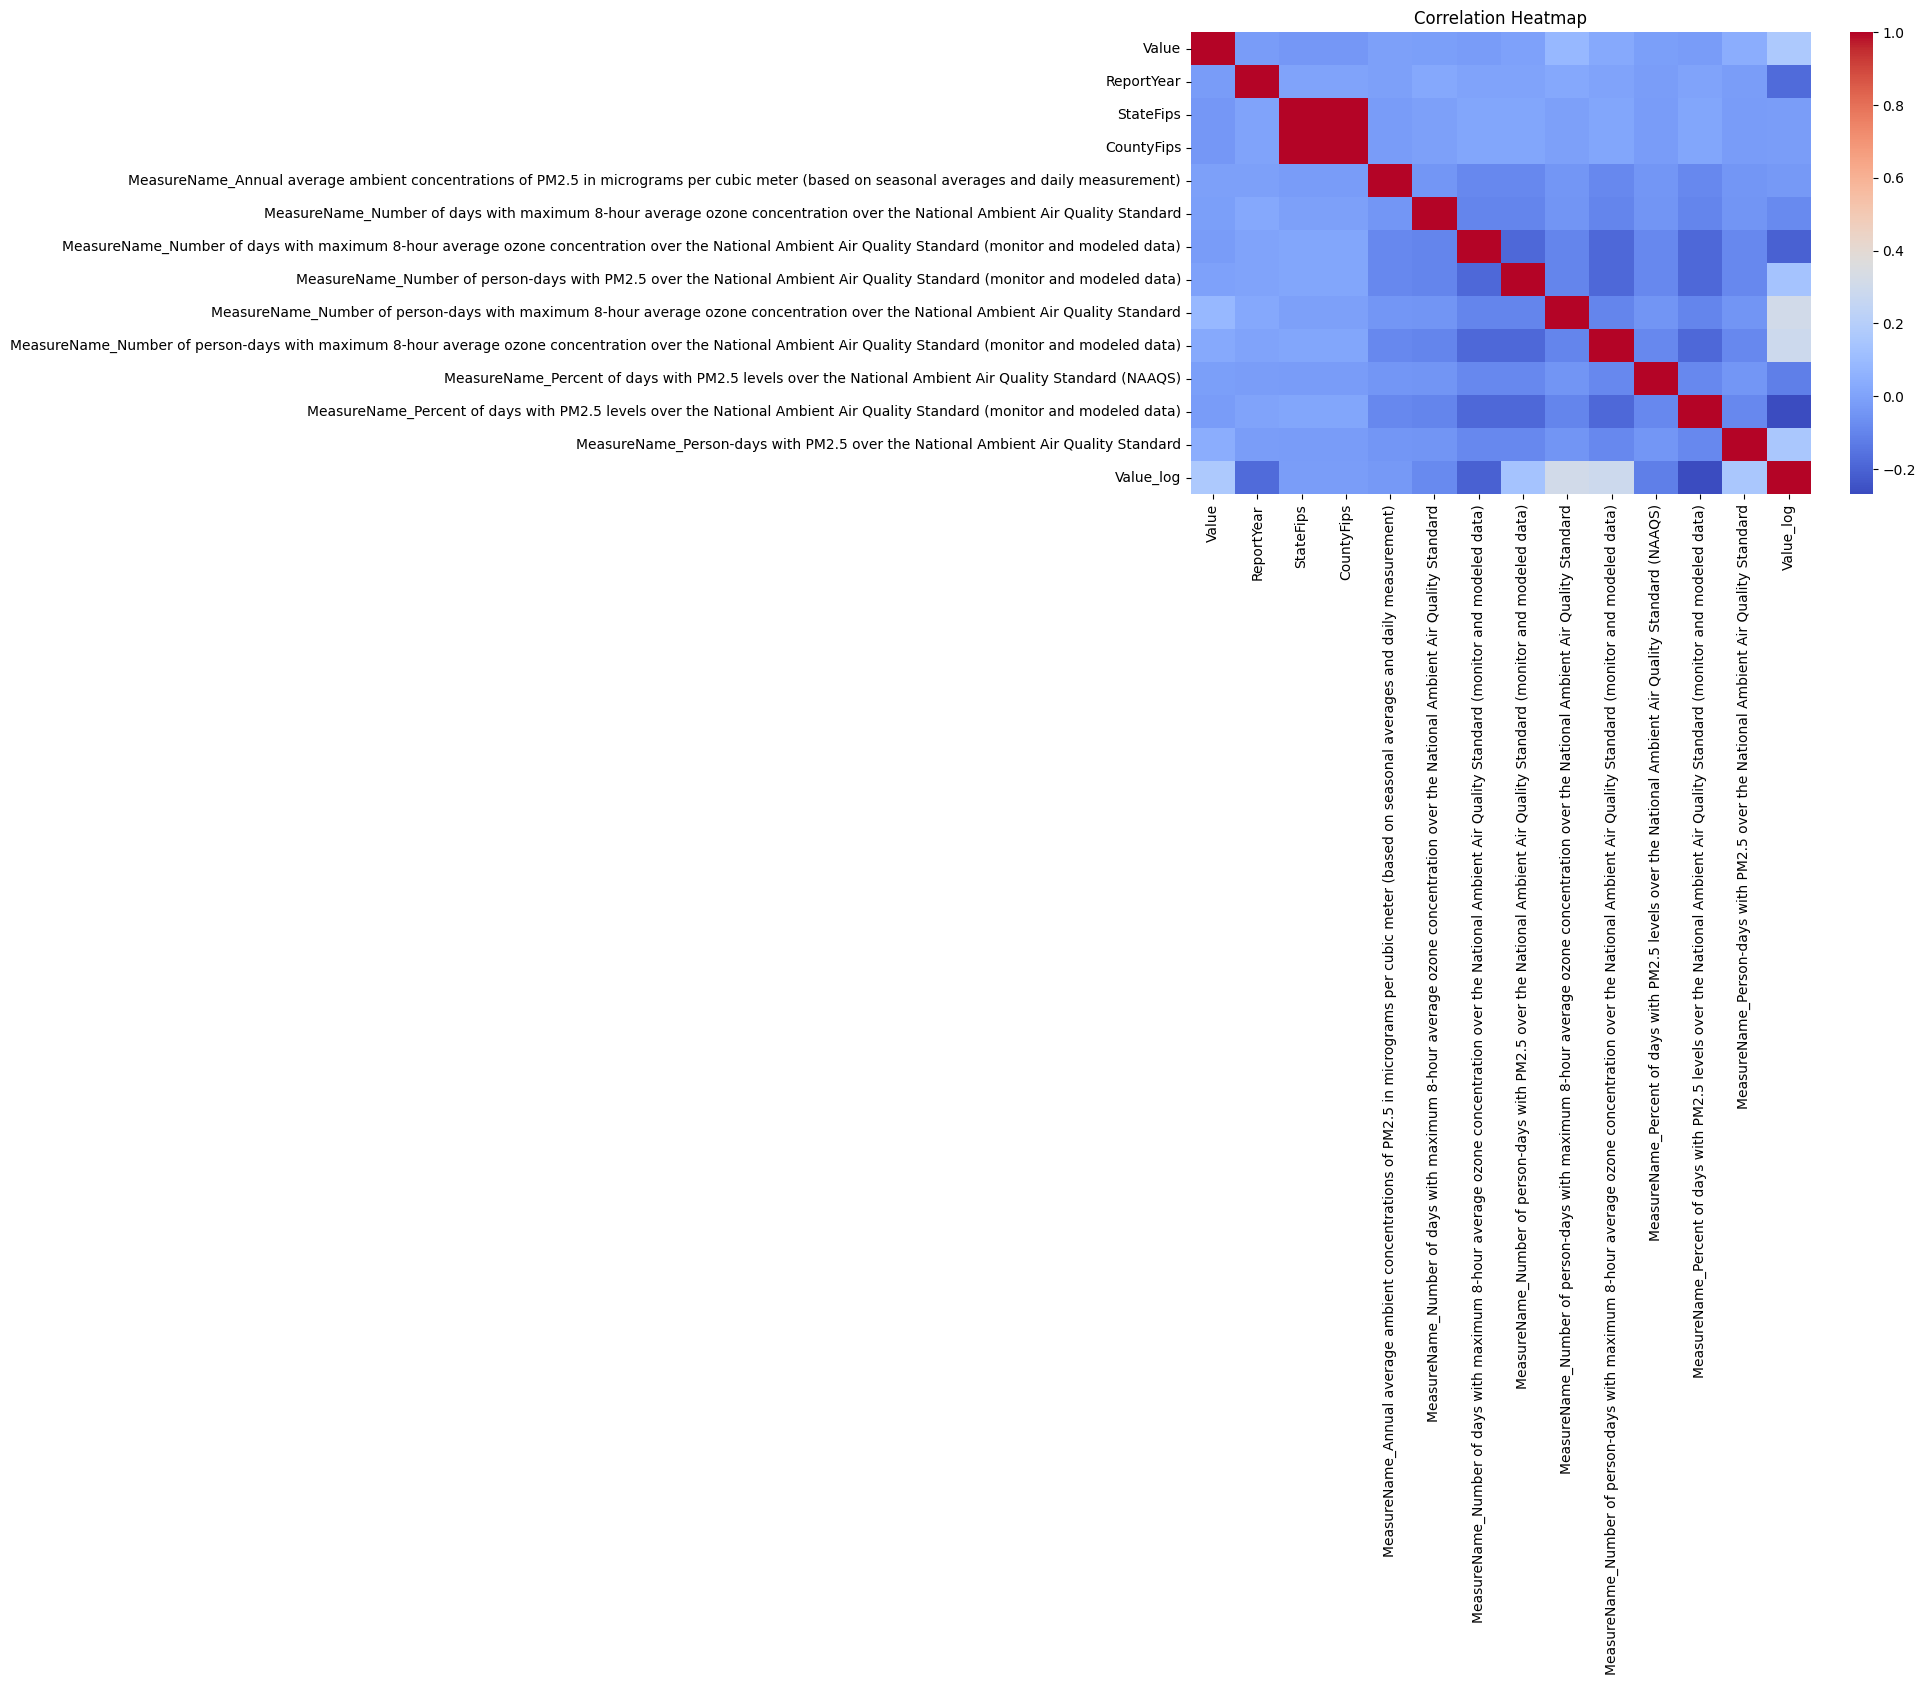

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


In [ ]:
# ==============================
# Step 10: Define X and y
# ==============================

X = df.drop(['Value', 'Value_log'], axis=1)
y = df['Value_log']


In [ ]:
# ==============================
# Step 11: Train-test split
# ==============================

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [ ]:
# ==============================
# Step 12: Feature scaling
# ==============================

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
# ==============================
# Step 13: Model training
# ==============================

lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)


LinearRegression()

In [ ]:
# ==============================
# Step 14: Evaluation
# ==============================

y_pred = lr_model.predict(X_test_scaled)

print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred))
print("R-squared (R²):", r2_score(y_test, y_pred))


Mean Absolute Error (MAE): 2.7770726060406488
Mean Squared Error (MSE): 15.299257568322815
R-squared (R²): 0.34902976890590887


In [ ]:
# ==============================
# Step 15: Baseline model
# ==============================

baseline_pred = np.full_like(y_test, y_train.mean())

print("Baseline MAE:", mean_absolute_error(y_test, baseline_pred))
print("Baseline R²:", r2_score(y_test, baseline_pred))


Baseline MAE: 3.756421732912094
Baseline R²: -4.598847934267347e-05


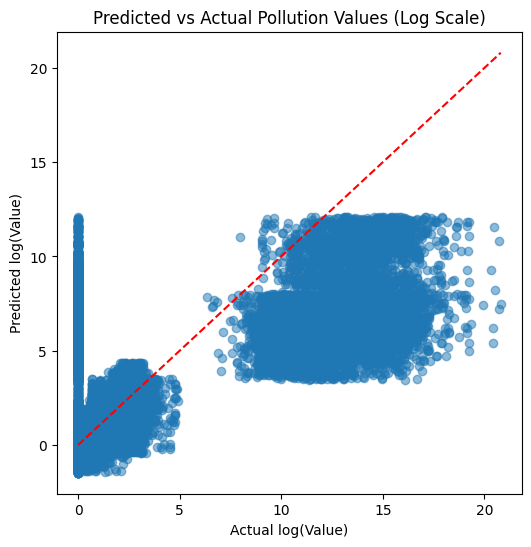

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual log(Value)")
plt.ylabel("Predicted log(Value)")
plt.title("Predicted vs Actual Pollution Values (Log Scale)")
plt.show()


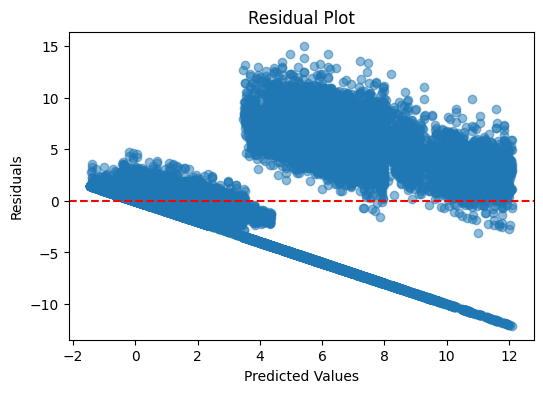

In [ ]:
residuals = y_test - y_pred

plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()


In [ ]:
# ==============================
# Step 18: SHAP explainability
# ==============================

# SHAP explains how each feature contributes to predictions
explainer = shap.Explainer(lr_model, X_train_scaled)
shap_values = explainer(X_test_scaled)


/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:1150: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


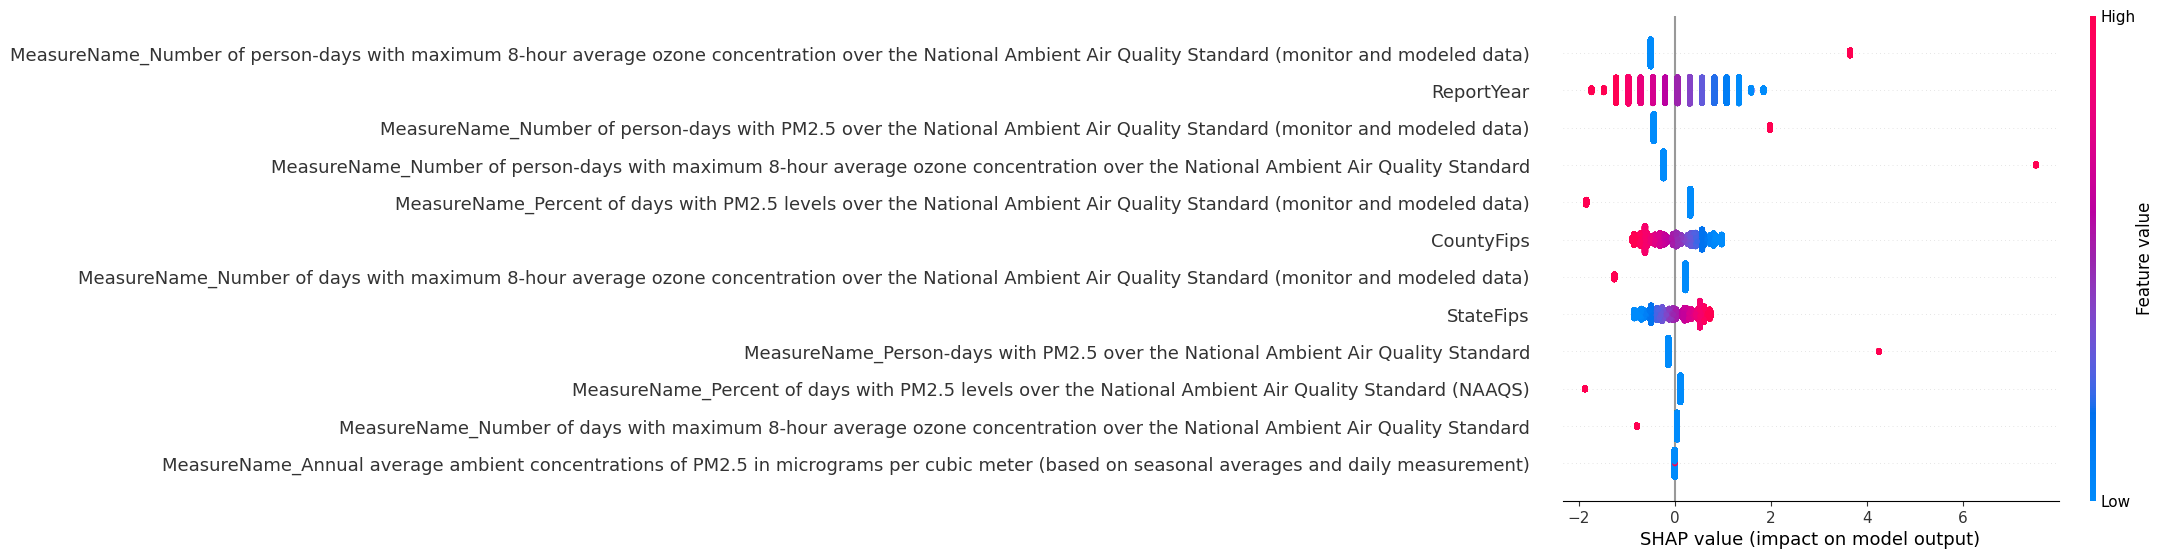

In [ ]:
# Global feature importance
shap.summary_plot(
    shap_values,
    X_test,
    feature_names=X.columns
)
